In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

In [81]:
stock = "YESBANK.NS"
df = si.get_data(stock)

In [82]:
# df = pd.read_csv("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/GoogleStockPricePrediction/GOOG2.csv")
# df = pd.read_csv("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/TATAMOTORS.NS test.csv")
# df.head()

In [83]:
df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
df = df[df["volume"]>0]
df.head()

,Date,open,high,low,close,adjclose,volume,ticker
0,2005-07-12,13.18,14.00,12.00,12.17,7.810764,244941515.0,YESBANK.NS
1,2005-07-13,12.20,12.60,11.49,11.74,7.534786,64111620.0,YESBANK.NS
2,2005-07-14,12.00,12.00,11.40,11.45,7.348665,16282865.0,YESBANK.NS
3,2005-07-15,11.25,12.89,11.25,12.37,7.939126,75448030.0,YESBANK.NS
4,2005-07-18,12.54,13.14,12.50,12.82,8.227937,75684775.0,YESBANK.NS


In [84]:
df["Date"].min(), df["Date"].max()

(Timestamp('2005-07-12 00:00:00'), Timestamp('2020-11-06 00:00:00'))

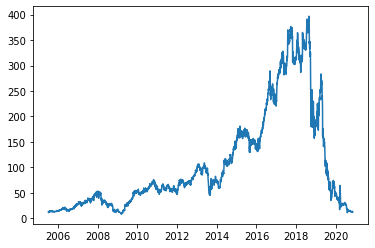

In [85]:
split_date = '2020-01-01'
df_data_training = df[df["Date"]<split_date]
df_data_test = df[df["Date"]>=split_date]
plt.plot(df["Date"],df["open"])

In [86]:
df_data_training.head()
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )

Training Size : 3551, Test Size : 214


In [87]:
data_training = df_data_training.drop(["Date", "adjclose", "ticker"], axis=1)
data_training.dropna(inplace=True)

In [88]:
scaler = MinMaxScaler()
training_Dataset = scaler.fit_transform(data_training)
training_Dataset.shape

(3551, 5)

In [89]:
training_window = 60
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [90]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))

Shape of X is : (3491, 60, 5), Shape of Y is : (3491,)


In [91]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
X_train.shape[1]
tf.optimizers

<module 'tensorflow.keras.optimizers' from '/usr/local/lib/python3.8/site-packages/tensorflow/keras/optimizers/__init__.py'>

In [92]:
model = Sequential([
    LSTM(units=60, activation='relu', return_sequences = True, input_shape = (60,5)),
    Dropout(0.2),
    LSTM(units=60, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=120, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 60)            15840     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 120)              

In [93]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 1e-03:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [94]:
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError())
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=500, callbacks = CustomCallback())

Epoch 1/500
110/110 [==============================] - 11s 98ms/step - loss: 0.0146
Epoch 2/500
110/110 [==============================] - 10s 91ms/step - loss: 0.0054
Epoch 3/500
110/110 [==============================] - 10s 88ms/step - loss: 0.0042
Epoch 4/500
110/110 [==============================] - 9s 86ms/step - loss: 0.0033
Epoch 5/500
110/110 [==============================] - 10s 94ms/step - loss: 0.0031
Epoch 6/500
110/110 [==============================] - 10s 89ms/step - loss: 0.0030
Epoch 7/500
110/110 [==============================] - 10s 91ms/step - loss: 0.0026
Epoch 8/500
110/110 [==============================] - 10s 89ms/step - loss: 0.0024
Epoch 9/500
110/110 [==============================] - 10s 95ms/step - loss: 0.0022
Epoch 10/500
110/110 [==============================] - 10s 91ms/step - loss: 0.0021
Epoch 11/500
110/110 [==============================] - 10s 90ms/step - loss: 0.0020
Epoch 12/500
110/110 [==============================] - 10s 87ms/step - los

In [95]:
test_pred = model.predict(X_train)
model.evaluate(X_train, y_train)
test_pred.shape
# data_test.head()

110/110 [==============================] - 3s 23ms/step - loss: 9.7209e-04


(3491, 1)

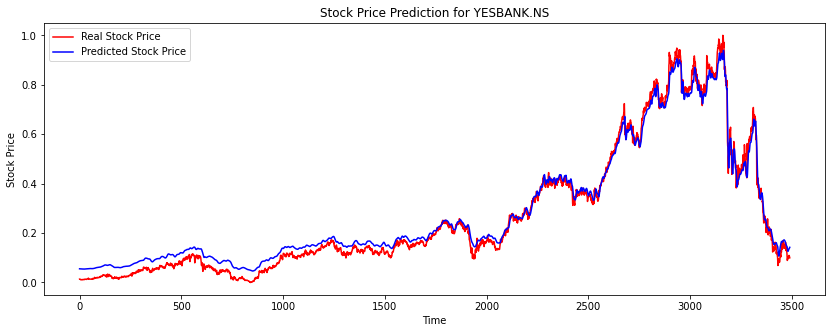

In [96]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train, color = 'red', label = 'Real Stock Price')
plt.plot(test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for {}'.format(stock))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/training_output.jpeg", dpi=300)
plt.show()

In [97]:
past_60_days = df_data_training.tail(60)

In [98]:
df = past_60_days.append(df_data_test, ignore_index = True)
df = df.drop(['Date', 'adjclose', 'ticker'], axis = 1)
df.dropna(inplace=True)
df.head()

,open,high,low,close,volume
0,42.000000,44.299999,29.000000,32.000000,808959169.0
1,35.200001,43.450001,35.200001,42.500000,584506441.0
2,45.000000,45.900002,40.950001,42.150002,512643766.0
3,45.950001,46.799999,42.799999,45.650002,355287494.0
4,45.450001,45.450001,41.049999,43.250000,343533101.0


In [99]:
inputs = scaler.transform(df)
# inputs

In [100]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((214, 60, 5), (214,))

In [101]:
y_pred = model.predict(X_test)
y_pred.shape

(214, 1)

In [102]:
scaler.scale_

array([2.57599184e-03, 2.52908447e-03, 2.60125389e-03, 2.59282306e-03,
       1.19494953e-09])

In [103]:
scale = 1/scaler.scale_[0]
scale

388.199987411499

In [104]:
y_pred = y_pred*scale
y_test = y_test*scale
y_pred.shape

(214, 1)

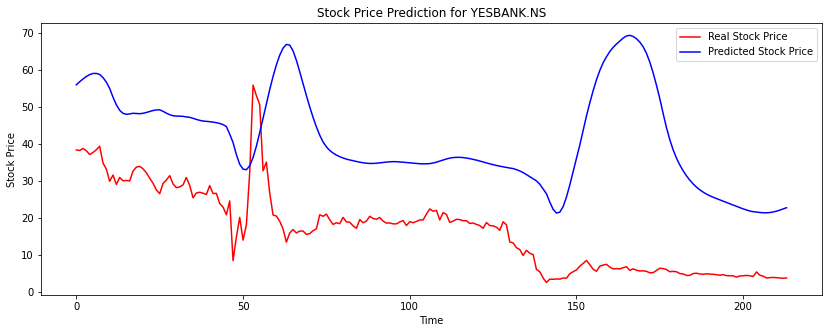

In [105]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for {}'.format(stock))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/test_output.jpeg", dpi=300)
plt.show()